In [1]:
# Cell 1: Config + imports
!pip install wfdb -q
import os, time, copy, random, ast
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm

# Paths (adjust)
KAGGLE_PATH = '/kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
CACHE_DIR = '/kaggle/working/ptbxl_cache'
OUT_DIR = "ts_jepa_logs"
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Hyperparams (tweak as needed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 50
N_PATCHES = 16
MASK_RATIO = 0.4
SAMPLING_RATE = 100
EXPECTED_SECONDS = 10
EXPECTED_LEN = SAMPLING_RATE * EXPECTED_SECONDS
PATCH_LEN = EXPECTED_LEN // N_PATCHES
EMBED_DIM = 256
LR = 1e-5
EMA_DECAY = 0.995
SEED = 42
NUM_WORKERS = 2

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)
print("Patch len:", PATCH_LEN)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:00
Device: cuda
Patch len: 62


In [2]:
# Cell 2: Load signals -> X_filtered (N,T,C) and y_filtered (labels)
# If cache exists, will load from CACHE_DIR; otherwise uses wfdb to build.
import os, numpy as np, pandas as pd, ast
USE_WFDB = True  # set False if you only have cached npy/csv

FILE_COL = 'filename_lr' if SAMPLING_RATE == 100 else 'filename_hr'
if not (os.path.exists(os.path.join(CACHE_DIR, 'X_filtered.npy')) and os.path.exists(os.path.join(CACHE_DIR,'y_filtered.csv'))):
    if not USE_WFDB:
        raise RuntimeError("Cached files not found and USE_WFDB=False.")
    try:
        import wfdb
    except Exception as e:
        raise RuntimeError("Install wfdb (`pip install wfdb`) to read PTB-XL records.") from e

    meta_csv = os.path.join(KAGGLE_PATH, 'ptbxl_database.csv')
    scp_csv  = os.path.join(KAGGLE_PATH, 'scp_statements.csv')
    if not os.path.exists(meta_csv):
        raise RuntimeError(f"PTB-XL metadata not found at {meta_csv}. Adjust KAGGLE_PATH.")

    meta = pd.read_csv(meta_csv, index_col='ecg_id')
    def safe_parse_scpcodes(s):
        try:
            return ast.literal_eval(s) if pd.notna(s) else {}
        except Exception:
            return {}
    meta['scp_codes'] = meta['scp_codes'].apply(safe_parse_scpcodes)

    agg_df = pd.read_csv(scp_csv, index_col=0)
    agg_df = agg_df[agg_df['diagnostic'] == 1]

    def aggregate_diagnostic(y_dic):
        out = []
        for k in y_dic.keys():
            if k in agg_df.index:
                out.append(agg_df.loc[k, 'diagnostic_class'])
        return list(set(out))

    meta['diagnostic_superclass'] = meta['scp_codes'].apply(aggregate_diagnostic)
    mask = meta['diagnostic_superclass'].apply(lambda x: len(x) == 1)
    meta_filtered = meta[mask].copy()
    meta_filtered['diagnostic_superclass'] = meta_filtered['diagnostic_superclass'].apply(lambda x: x[0])
    meta_filtered = meta_filtered.reset_index()
    print("Filtered samples:", len(meta_filtered))
    records_dir = KAGGLE_PATH

    def load_signal_safe(record_name, records_dir):
        try:
            sig, fields = wfdb.rdsamp(os.path.join(records_dir, record_name))
            return sig
        except Exception:
            base = os.path.splitext(record_name)[0]
            try:
                sig, fields = wfdb.rdsamp(os.path.join(records_dir, base))
                return sig
            except Exception:
                try:
                    sig, fields = wfdb.rdsamp(record_name)
                    return sig
                except Exception:
                    return None

    signals = []; labels = []; failed = []
    for _, row in tqdm(meta_filtered.iterrows(), total=len(meta_filtered)):
        rec_name = row[FILE_COL]
        sig = load_signal_safe(rec_name, records_dir)
        if sig is None:
            failed.append(rec_name); continue
        sig = np.asarray(sig, dtype=np.float32)
        n_samples, n_leads = sig.shape
        if n_samples < EXPECTED_LEN:
            pad_len = EXPECTED_LEN - n_samples
            sig = np.pad(sig, ((0, pad_len),(0,0)), mode='constant')
        elif n_samples > EXPECTED_LEN:
            sig = sig[:EXPECTED_LEN, :]
        signals.append(sig)
        labels.append(row['diagnostic_superclass'])

    print("Loaded:", len(signals), "Failed:", len(failed))
    X_filtered = np.stack(signals).astype(np.float32)  # (N, T, C)
    y_filtered = pd.Series(labels)
    np.save(os.path.join(CACHE_DIR,'X_filtered.npy'), X_filtered)
    y_filtered.to_csv(os.path.join(CACHE_DIR,'y_filtered.csv'), index=False)
    print("Saved cache to", CACHE_DIR)
else:
    X_filtered = np.load(os.path.join(CACHE_DIR,'X_filtered.npy'))
    y_filtered = pd.read_csv(os.path.join(CACHE_DIR,'y_filtered.csv')).iloc[:,0]
    print("Loaded cached X_filtered/y_filtered from", CACHE_DIR)

print("X shape:", X_filtered.shape, "labels:", len(y_filtered))


Filtered samples: 16244


  0%|          | 0/16244 [00:00<?, ?it/s]

Loaded: 16244 Failed: 0
Saved cache to /kaggle/working/ptbxl_cache
X shape: (16244, 1000, 12) labels: 16244


In [3]:
# Cell 3: torch-native augmentations (used inside Dataset)
import torch

def _ensure_3d(x):
    return x.unsqueeze(0) if x.dim() == 2 else x

def jitter_torch(x, sigma=0.02):
    x3 = _ensure_3d(x); noise = torch.randn_like(x3) * float(sigma); x3 = x3 + noise
    return x3 if x.dim()==3 else x3[0]

def scaling_torch(x, sigma=0.1):
    x3 = _ensure_3d(x); B,C,T = x3.shape
    factors = torch.normal(1.0, sigma, size=(B,C,1), device=x3.device, dtype=x3.dtype)
    return (x3 * factors) if x.dim()==3 else (x3 * factors)[0]

def random_shift_torch(x, shift_max_frac=0.05):
    x3 = _ensure_3d(x); B,C,T = x3.shape
    max_shift = int(abs(shift_max_frac)*T)
    if max_shift <= 0: return x if x.dim()==2 else x3
    shifts = torch.randint(-max_shift, max_shift+1, (B,), device=x3.device)
    out = torch.zeros_like(x3)
    for i, s in enumerate(shifts):
        s = int(s.item())
        if s > 0: out[i,:,s:] = x3[i,:,:-s]
        elif s < 0: ss=-s; out[i,:,:T-ss] = x3[i,:,ss:]
        else: out[i] = x3[i]
    return out if x.dim()==3 else out[0]

def time_mask_torch(x, max_mask_frac=0.1):
    x3 = _ensure_3d(x); B,C,T = x3.shape; x2 = x3.clone()
    for i in range(B):
        mask_len = int(torch.rand(1).item() * max_mask_frac * T)
        if mask_len <= 0: continue
        start = int(torch.randint(0, T - mask_len + 1, (1,), device=x3.device))
        x2[i,:,start:start+mask_len] = 0
    return x2 if x.dim()==3 else x2[0]

def aug_wrapper_torch(x):
    if torch.rand(1).item() < 0.5: x = jitter_torch(x)
    if torch.rand(1).item() < 0.3: x = scaling_torch(x)
    if torch.rand(1).item() < 0.3: x = random_shift_torch(x)
    if torch.rand(1).item() < 0.2: x = time_mask_torch(x)
    return x


In [4]:
# Cell 4: ResNet1D (1D variant). If you already have your ResNet, use it instead.
import torch.nn as nn

class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity; out = self.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, block=BasicBlock1D, layers=[2,2,2,2], in_channels=12, num_classes=5):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        x = self.fc(x)
        return x

def build_resnet18_1d(in_channels, num_classes):
    return ResNet1D(in_channels=in_channels, num_classes=num_classes)


In [5]:
# Cell 5: patch splitting + backbone wrapper + PatchEncoder
def split_into_patches_np(x, n_patches=N_PATCHES, patch_len=PATCH_LEN):
    C, T = x.shape
    needed = n_patches * patch_len
    if T < needed:
        x = np.pad(x, ((0,0),(0, needed-T)), mode='constant')
    elif T > needed:
        x = x[:, :needed]
    patches = [ x[:, i*patch_len:(i+1)*patch_len] for i in range(n_patches) ]
    return np.stack(patches, axis=0).astype(np.float32)

class _BackboneForPatches(nn.Module):
    def __init__(self, resnet: ResNet1D):
        super().__init__()
        self.conv1 = resnet.conv1; self.bn1 = resnet.bn1; self.relu = resnet.relu; self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1; self.layer2 = resnet.layer2; self.layer3 = resnet.layer3; self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.out_features = None
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        if self.out_features is None:
            self.out_features = x.shape[1]
        return x

class PatchEncoder(nn.Module):
    def __init__(self, resnet_instance, embed_dim=EMBED_DIM):
        super().__init__()
        self.backbone = _BackboneForPatches(resnet_instance)
        self.embed_dim = embed_dim
        self.projector = None
    def _build_projector(self, feat_dim, device=None, dtype=None):
        proj = nn.Sequential(nn.Linear(feat_dim, self.embed_dim), nn.ReLU(inplace=True), nn.Linear(self.embed_dim, self.embed_dim))
        if device is not None: proj.to(device)
        if dtype is not None: proj = proj.to(dtype=dtype)
        self.projector = proj
    def forward(self, patches):
        B,P,C,L = patches.shape
        x = patches.reshape(B*P, C, L)
        feats = self.backbone(x)
        if self.projector is None:
            self._build_projector(feats.shape[1], device=feats.device, dtype=feats.dtype)
        z = self.projector(feats)
        return z.view(B, P, -1)


In [6]:
# Cell 6: JEPA model with internal EMA target
@torch.no_grad()
def _update_ema_params_and_buffers(target, online, m):
    for p_t, p_o in zip(target.parameters(), online.parameters()):
        p_t.data.mul_(m).add_(p_o.data * (1.0 - m))
    for b_t, b_o in zip(target.buffers(), online.buffers()):
        try: b_t.copy_(b_o)
        except Exception: pass

class JEPA_Model(nn.Module):
    def __init__(self, patch_encoder: PatchEncoder, n_patches=N_PATCHES, embed_dim=EMBED_DIM,
                 transformer_layers=2, heads=4, predictor_hidden=512, momentum=EMA_DECAY):
        super().__init__()
        self.online_patch_encoder = patch_encoder
        self.target_patch_encoder = copy.deepcopy(patch_encoder)
        for p in self.target_patch_encoder.parameters(): p.requires_grad = False
        self.n_patches = n_patches; self.embed_dim = embed_dim
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, dim_feedforward=embed_dim*2, activation='relu')
        self.context_net = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)
        self.predictor = nn.Sequential(nn.Linear(embed_dim, predictor_hidden), nn.ReLU(inplace=True), nn.Linear(predictor_hidden, embed_dim))
        self.momentum = float(momentum)

    def context_forward(self, z_visible):
        z = z_visible + self.pos_embed[:, :z_visible.size(1), :].to(z_visible.device)
        x = z.permute(1,0,2); c = self.context_net(x)
        return c.permute(1,0,2)

    def forward_predict(self, z_masked):
        return self.predictor(self.context_forward(z_masked))

    def forward_train(self, patches, mask):
        device = patches.device; B,P,C,L = patches.shape
        all_z_online = self.online_patch_encoder(patches)   # (B,P,D)
        visible_mask = ~mask
        n_vis = visible_mask.sum(dim=1)
        max_vis = int(n_vis.max().item())
        if max_vis == 0:
            raise RuntimeError("All patches masked in batch; reduce MASK_RATIO")
        z_vis_list = []
        for b in range(B):
            idx = torch.nonzero(visible_mask[b], as_tuple=False).squeeze(-1)
            if idx.numel() == 0:
                pad = torch.zeros((max_vis, all_z_online.size(-1)), device=device, dtype=all_z_online.dtype)
                z_sel = pad
            else:
                z_sel = all_z_online[b, idx, :]
                if z_sel.size(0) < max_vis:
                    pad = torch.zeros((max_vis - z_sel.size(0), z_sel.size(1)), device=device, dtype=z_sel.dtype)
                    z_sel = torch.cat([z_sel, pad], dim=0)
            z_vis_list.append(z_sel.unsqueeze(0))
        z_visible = torch.cat(z_vis_list, dim=0)
        preds = self.forward_predict(z_visible)
        with torch.no_grad():
            all_z_target = self.target_patch_encoder(patches)
            target_list = []
            for b in range(B):
                idx_masked = torch.nonzero(mask[b], as_tuple=False).squeeze(-1)
                if idx_masked.numel() == 0:
                    t = torch.zeros((0, all_z_target.size(-1)), device=device, dtype=all_z_target.dtype)
                else:
                    t = all_z_target[b, idx_masked, :]
                target_list.append(t)
            npred = preds.size(1)
            padded_targets = []
            for t in target_list:
                if t.size(0) < npred:
                    pad = torch.zeros((npred - t.size(0), t.size(1)), device=device, dtype=t.dtype)
                    t_p = torch.cat([t, pad], dim=0)
                elif t.size(0) > npred:
                    t_p = t[:npred]
                else:
                    t_p = t
                padded_targets.append(t_p.unsqueeze(0))
            targets = torch.cat(padded_targets, dim=0)
        preds_n = F.normalize(preds, dim=-1); targets_n = F.normalize(targets, dim=-1)
        cos = (preds_n * targets_n).sum(dim=-1)
        loss = (1.0 - cos).mean()
        return loss

    def update_target(self):
        _update_ema_params_and_buffers(self.target_patch_encoder, self.online_patch_encoder, self.momentum)


In [7]:
# Cell 7: JEPA_Dataset returns (patches, mask)
class JEPA_Dataset(Dataset):
    def __init__(self, X, augment_fn=None, n_patches=N_PATCHES, patch_len=PATCH_LEN, mask_ratio=MASK_RATIO):
        assert isinstance(X, np.ndarray)
        self.X = X; self.augment_fn = augment_fn; self.n_patches = int(n_patches)
        self.patch_len = int(patch_len); self.mask_ratio = float(mask_ratio)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]        # (T,C)
        if x.ndim != 2: raise ValueError("Expected (T,C)")
        x_t = torch.from_numpy(x.T).float()   # (C, T)
        if self.augment_fn is not None: x_t = self.augment_fn(x_t)
        patches_np = split_into_patches_np(x_t.numpy(), n_patches=self.n_patches, patch_len=self.patch_len)
        patches = torch.from_numpy(patches_np.astype(np.float32))  # (P,C,L)
        n_mask = max(1, int(round(self.n_patches * self.mask_ratio)))
        masked_idx = np.random.choice(self.n_patches, size=n_mask, replace=False)
        mask_np = np.zeros((self.n_patches,), dtype=np.bool_); mask_np[masked_idx] = True
        mask = torch.from_numpy(mask_np)
        return patches, mask

# build dataset & loaders
dataset = JEPA_Dataset(X_filtered, augment_fn=aug_wrapper_torch, n_patches=N_PATCHES, patch_len=PATCH_LEN, mask_ratio=MASK_RATIO)
from sklearn.model_selection import train_test_split
all_idx = np.arange(len(dataset))
train_idx, val_idx = train_test_split(all_idx, test_size=0.1, random_state=SEED)
train_ds = Subset(dataset, train_idx); val_ds = Subset(dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS)

print("Train/val sizes:", len(train_ds), len(val_ds))


Train/val sizes: 14619 1625


In [8]:
# Cell 8: build backbone + patch encoder + JEPA model + optimizer
resnet_base = build_resnet18_1d(in_channels=X_filtered.shape[2], num_classes=5).to(DEVICE)
patch_enc_online = PatchEncoder(resnet_base, embed_dim=EMBED_DIM).to(DEVICE)
jepa = JEPA_Model(patch_enc_online, n_patches=N_PATCHES, embed_dim=EMBED_DIM).to(DEVICE)
opt = torch.optim.Adam(jepa.parameters(), lr=LR, weight_decay=1e-6)

# quick sanity batch
b0 = next(iter(train_loader))
patches, mask = b0  # patches: (B,P,C,L), mask: (B,P)
print("Batch shapes (CPU):", patches.shape, mask.shape)
patches = patches.to(DEVICE).float(); mask = mask.to(DEVICE).bool()

# unit forward + grad check
jepa.train()
loss = jepa.forward_train(patches, mask)
loss.backward()
online_has_grad = any((p.grad is not None) for p in jepa.online_patch_encoder.parameters())
target_has_grad = any((p.grad is not None) for p in jepa.target_patch_encoder.parameters())
print("Loss:", float(loss.item()), "online_has_grad:", online_has_grad, "target_has_grad:", target_has_grad)
opt.step(); opt.zero_grad(); jepa.update_target()
print("EMA update done.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Batch shapes (CPU): torch.Size([256, 16, 12, 62]) torch.Size([256, 16])
Loss: 1.0152028799057007 online_has_grad: True target_has_grad: False
EMA update done.


In [9]:
# Cell 9: full training loop (run EPOCHS)
history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'epoch_time_s': []}
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    jepa.train(); running_loss = 0.0; seen = 0
    pbar = tqdm(train_loader, desc=f"JEPA train {epoch}/{EPOCHS}")
    for patches, mask in pbar:
        patches = patches.to(DEVICE).float(); mask = mask.to(DEVICE).bool()
        opt.zero_grad()
        loss = jepa.forward_train(patches, mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(jepa.parameters(), 1.0)
        opt.step()
        jepa.update_target()
        B = patches.size(0)
        running_loss += float(loss.item()) * B
        seen += B
        pbar.set_postfix(train_loss = running_loss / (seen if seen else 1.0))
    avg_train = running_loss / (seen if seen else 1.0)

    # validation
    jepa.eval(); val_running = 0.0; val_seen = 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f"JEPA val {epoch}/{EPOCHS}")
        for patches, mask in vbar:
            patches = patches.to(DEVICE).float(); mask = mask.to(DEVICE).bool()
            loss_val = jepa.forward_train(patches, mask)
            val_running += float(loss_val.item()) * patches.size(0)
            val_seen += patches.size(0)
            vbar.set_postfix(val_loss = val_running / (val_seen if val_seen else 1.0))
    avg_val = val_running / (val_seen if val_seen else 1.0)
    epoch_time = time.time() - t0

    history['epoch'].append(epoch); history['train_loss'].append(avg_train); history['val_loss'].append(avg_val); history['epoch_time_s'].append(epoch_time)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss={avg_train:.6f}  val_loss={avg_val:.6f}  time={epoch_time:.1f}s")

    ck = {'epoch': epoch, 'jepa_state': jepa.state_dict(), 'opt': opt.state_dict(), 'history': history}
    torch.save(ck, os.path.join(OUT_DIR, f"jepa_epoch_{epoch}.pth"))


JEPA train 1/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/50 — train_loss=0.862724  val_loss=0.730445  time=23.8s


JEPA train 2/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/50 — train_loss=0.633446  val_loss=0.577370  time=23.6s


JEPA train 3/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/50 — train_loss=0.529502  val_loss=0.518422  time=23.6s


JEPA train 4/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/50 — train_loss=0.498390  val_loss=0.489117  time=23.7s


JEPA train 5/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/50 — train_loss=0.484341  val_loss=0.471994  time=23.7s


JEPA train 6/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/50 — train_loss=0.474766  val_loss=0.463826  time=23.8s


JEPA train 7/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/50 — train_loss=0.467724  val_loss=0.458678  time=23.6s


JEPA train 8/50:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Exception ignored in: self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

         if

JEPA val 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/50 — train_loss=0.462802  val_loss=0.454881  time=28.1s


JEPA train 9/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/50 — train_loss=0.459281  val_loss=0.450749  time=23.7s


JEPA train 10/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/50 — train_loss=0.456954  val_loss=0.448978  time=23.5s


JEPA train 11/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/50 — train_loss=0.455078  val_loss=0.450179  time=23.7s


JEPA train 12/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/50 — train_loss=0.453889  val_loss=0.447810  time=23.6s


JEPA train 13/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/50 — train_loss=0.452959  val_loss=0.446453  time=23.7s


JEPA train 14/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/50 — train_loss=0.452408  val_loss=0.447503  time=23.6s


JEPA train 15/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 15/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/50 — train_loss=0.452133  val_loss=0.444214  time=23.7s


JEPA train 16/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 16/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/50 — train_loss=0.451710  val_loss=0.439011  time=184.2s


JEPA train 17/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 17/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/50 — train_loss=0.451628  val_loss=0.444854  time=23.6s


JEPA train 18/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 18/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/50 — train_loss=0.451197  val_loss=0.446069  time=23.7s


JEPA train 19/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 19/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/50 — train_loss=0.451311  val_loss=0.445236  time=23.7s


JEPA train 20/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 20/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/50 — train_loss=0.451165  val_loss=0.445104  time=23.7s


JEPA train 21/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 21/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/50 — train_loss=0.451460  val_loss=0.446705  time=23.7s


JEPA train 22/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 22/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/50 — train_loss=0.451733  val_loss=0.444023  time=23.6s


JEPA train 23/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 23/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/50 — train_loss=0.451844  val_loss=0.450599  time=23.8s


JEPA train 24/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 24/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/50 — train_loss=0.452161  val_loss=0.449648  time=23.8s


JEPA train 25/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 25/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/50 — train_loss=0.452705  val_loss=0.449873  time=204.3s


JEPA train 26/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 26/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/50 — train_loss=0.452909  val_loss=0.448337  time=23.6s


JEPA train 27/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 27/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/50 — train_loss=0.453437  val_loss=0.450590  time=23.7s


JEPA train 28/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 28/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/50 — train_loss=0.454275  val_loss=0.450854  time=23.6s


JEPA train 29/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 29/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/50 — train_loss=0.454899  val_loss=0.450771  time=23.7s


JEPA train 30/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 30/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/50 — train_loss=0.455110  val_loss=0.453660  time=23.7s


JEPA train 31/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 31/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/50 — train_loss=0.455481  val_loss=0.453409  time=23.6s


JEPA train 32/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 32/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/50 — train_loss=0.456400  val_loss=0.451201  time=23.7s


JEPA train 33/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 33/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/50 — train_loss=0.456564  val_loss=0.453077  time=23.7s


JEPA train 34/50:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

JEPA val 34/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/50 — train_loss=0.457103  val_loss=0.455540  time=206.3s


JEPA train 35/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 35/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/50 — train_loss=0.457804  val_loss=0.456361  time=23.8s


JEPA train 36/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 36/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/50 — train_loss=0.458164  val_loss=0.454325  time=23.7s


JEPA train 37/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 37/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/50 — train_loss=0.458331  val_loss=0.457962  time=23.7s


JEPA train 38/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 38/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/50 — train_loss=0.459043  val_loss=0.458191  time=23.8s


JEPA train 39/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 39/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/50 — train_loss=0.459415  val_loss=0.457341  time=23.9s


JEPA train 40/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 40/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/50 — train_loss=0.460009  val_loss=0.458316  time=23.8s


JEPA train 41/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 41/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/50 — train_loss=0.460653  val_loss=0.460692  time=23.7s


JEPA train 42/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 42/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/50 — train_loss=0.461196  val_loss=0.460056  time=23.6s


JEPA train 43/50:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7c68fb0900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

JEPA val 43/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/50 — train_loss=0.461611  val_loss=0.461793  time=206.7s


JEPA train 44/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 44/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/50 — train_loss=0.462029  val_loss=0.461990  time=24.1s


JEPA train 45/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 45/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/50 — train_loss=0.462976  val_loss=0.459945  time=23.9s


JEPA train 46/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 46/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/50 — train_loss=0.463342  val_loss=0.459845  time=23.9s


JEPA train 47/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 47/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/50 — train_loss=0.463977  val_loss=0.462555  time=23.9s


JEPA train 48/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 48/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/50 — train_loss=0.465023  val_loss=0.463764  time=24.0s


JEPA train 49/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 49/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/50 — train_loss=0.465661  val_loss=0.466257  time=24.0s


JEPA train 50/50:   0%|          | 0/57 [00:00<?, ?it/s]

JEPA val 50/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/50 — train_loss=0.466434  val_loss=0.465623  time=23.8s


Saved history and plot to ts_jepa_logs


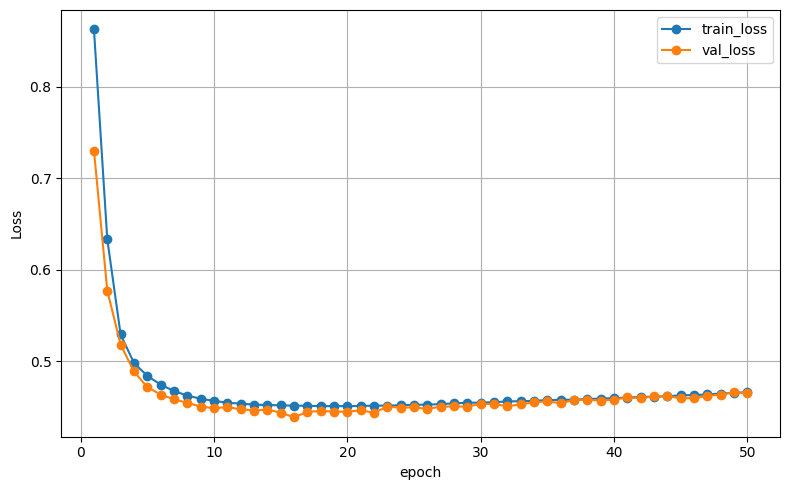

In [10]:
# Cell 10: save plot + CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history['epoch'], history['train_loss'], marker='o', label='train_loss')
plt.plot(history['epoch'], history['val_loss'], marker='o', label='val_loss')
plt.xlabel('epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'train_val_loss_curve.png'), dpi=150)
import pandas as pd
pd.DataFrame(history).to_csv(os.path.join(OUT_DIR, 'jepa_history.csv'), index=False)
print("Saved history and plot to", OUT_DIR)


In [11]:
# Cell 11: compute reps using EMA target encoder and save
def compute_reps(encoder_module, X_np, batch_size=64, device=DEVICE):
    encoder_module.eval()
    reps_list = []
    with torch.no_grad():
        for i in range(0, len(X_np), batch_size):
            batch = X_np[i:i+batch_size]
            patches = np.stack([split_into_patches_np(x.transpose(1,0)) for x in batch], axis=0)
            patches_t = torch.from_numpy(patches).to(device=device, dtype=torch.float32)
            z = encoder_module(patches_t)  # (B,P,D)
            rep = z.mean(dim=1).cpu().numpy()
            reps_list.append(rep)
    reps = np.concatenate(reps_list, axis=0)
    return reps

encoder_for_reps = jepa.target_patch_encoder
reps = compute_reps(encoder_for_reps, X_filtered, batch_size=64, device=DEVICE)
np.save(os.path.join(OUT_DIR, "reps.npy"), reps)
pd.Series(y_filtered).to_csv(os.path.join(OUT_DIR, "y_raw.csv"), index=False)
print("Saved reps and labels to", OUT_DIR, "reps shape:", reps.shape)


Saved reps and labels to ts_jepa_logs reps shape: (16244, 256)


In [12]:
# Cell 12: linear probe + SVM
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

y_raw = np.array(y_filtered)
le = LabelEncoder(); y_enc = le.fit_transform(y_raw); class_names = le.classes_.tolist()
i_train, i_test, y_train, y_test = train_test_split(np.arange(len(reps)), y_enc, test_size=0.20, stratify=y_enc, random_state=SEED)
X_train, X_test = reps[i_train], reps[i_test]

scaler = StandardScaler(); X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

lr = LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='multinomial', random_state=SEED)
lr.fit(X_train_s, y_train); y_pred_lr = lr.predict(X_test_s)
print("LogReg acc:", accuracy_score(y_test, y_pred_lr))
joblib.dump(lr, os.path.join(OUT_DIR, "linear_probe_logreg.joblib"))

svm_param_grid = {'C': [0.01, 0.1, 1.0, 5.0]}
svm = SVC(kernel='linear', probability=True, random_state=SEED)
gs = GridSearchCV(svm, svm_param_grid, cv=3, scoring='accuracy', n_jobs=2)
gs.fit(X_train_s, y_train)
svm_best = gs.best_estimator_
joblib.dump(svm_best, os.path.join(OUT_DIR, "svm_linear_best.joblib"))
y_pred_svm = svm_best.predict(X_test_s)
print("SVM acc:", accuracy_score(y_test, y_pred_svm))


LogReg acc: 0.6537396121883656
SVM acc: 0.6509695290858726


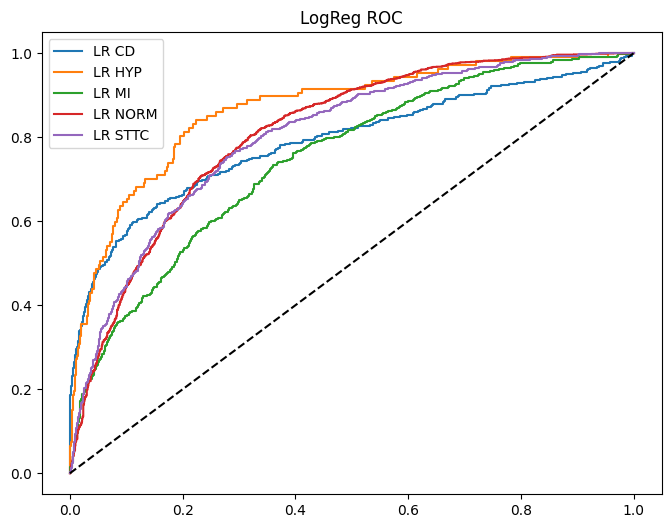

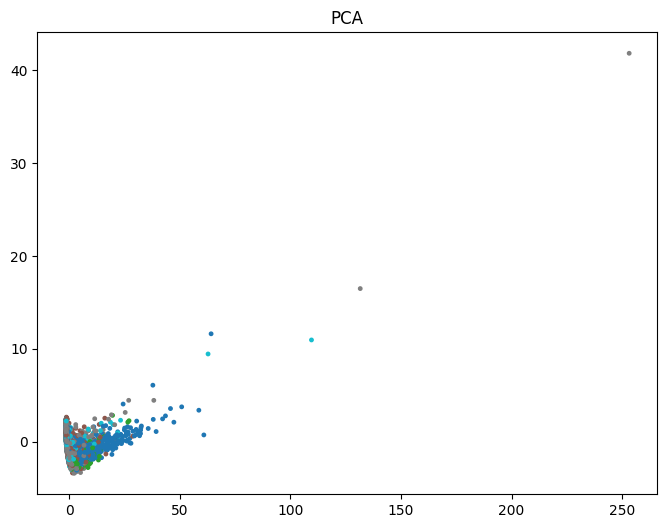

In [13]:
# Cell 13: ROC + PCA + t-SNE / UMAP (optional)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
from sklearn.metrics import roc_auc_score

# compute probabilities
y_prob_lr = lr.predict_proba(X_test_s)
y_prob_svm = svm_best.predict_proba(X_test_s)

# plot ROC for each class
plt.figure(figsize=(8,6))
for i, cname in enumerate(class_names):
    if np.sum(y_test_bin[:,i]) == 0: continue
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_prob_lr[:,i])
    plt.plot(fpr, tpr, label=f'LR {cname}')
plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title('LogReg ROC'); plt.savefig(os.path.join(OUT_DIR,'roc_logreg.png'))

# PCA
pca = PCA(n_components=2, random_state=SEED)
reps_pca = pca.fit_transform(reps)
plt.figure(figsize=(8,6))
plt.scatter(reps_pca[:,0], reps_pca[:,1], c=LabelEncoder().fit_transform(y_raw), s=6, cmap='tab10')
plt.title('PCA'); plt.savefig(os.path.join(OUT_DIR,'pca2d.png'))
